In [1]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt

images=glob.glob('camera_cal/calibration*.jpg')

#camera calibration
nx=9
ny=6
objpoints = []
imgpoints = []

objp=np.zeros((nx*ny,3),np.float32)
objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coord
#find points
for fname in images:
    img=cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)

#calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

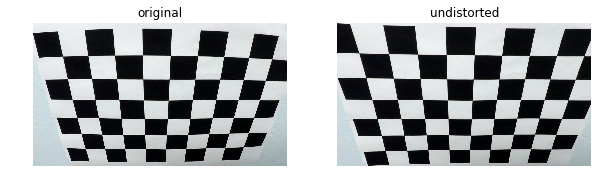

In [2]:
#undistort example - calibration image
img=cv2.imread('camera_cal/calibration2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(undist)
plt.axis('off')
plt.title('undistorted')

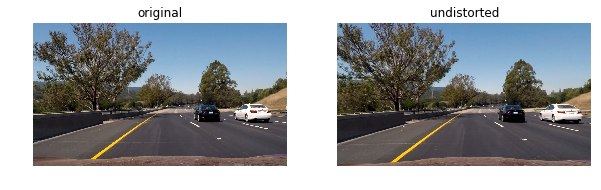

In [3]:
#undistort example images
import matplotlib.image as mpimg
test_images=glob.glob('test_images/straight_lines*.jpg')
test_images+=glob.glob('test_images/test*.jpg')
i=0
for imname in test_images:
    image = mpimg.imread(imname)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    mpimg.imsave("output"+test_images[i][4:-4]+"_undistort.jpg",undist)
    i+=1
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(undist)
plt.axis('off')
plt.title('undistorted')

In [4]:
# binarization function
def imbinarize(image):

    #RGB
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    rgb_thresh = (200, 255)
    binary = np.zeros_like(R)
        
    #gray
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_thresh = (225, 255)

    #HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    hls_thresh = (90, 255)
    
    binary[((R > rgb_thresh[0]) & (R <= rgb_thresh[1]))  &
           (((S > hls_thresh[0]) & (S <= hls_thresh[1])) | ((gray > gray_thresh[0]) & (gray <= gray_thresh[1]))) ] = 1
    return binary

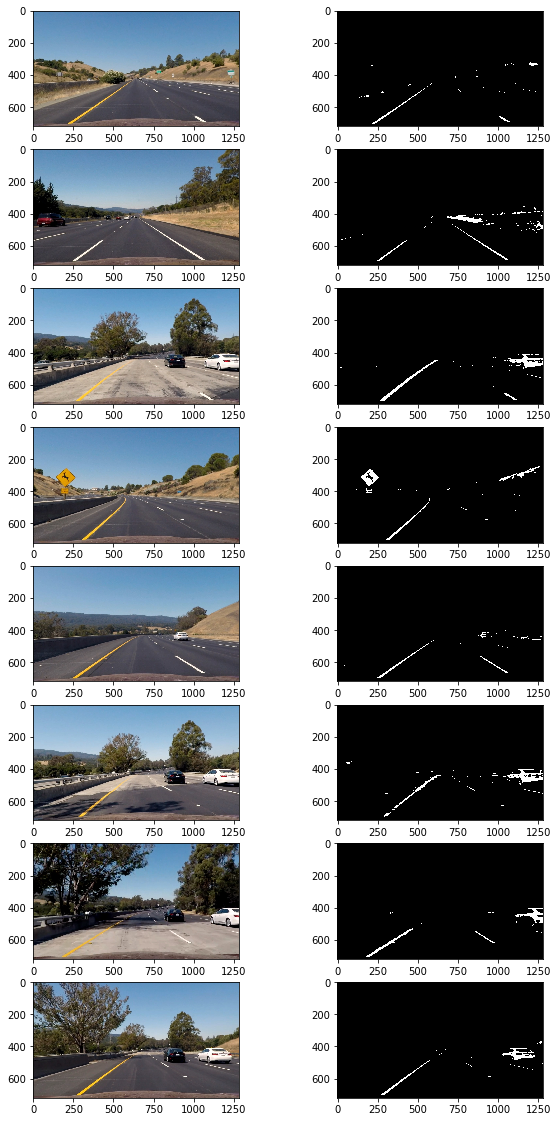

In [5]:
# binarization example
test_images=glob.glob('output_images/straight_lines*_undistort.jpg')
test_images+=glob.glob('output_images/test*_undistort.jpg')
#
plt.figure(figsize=(10,20))
i=0
for imname in test_images:
    image = mpimg.imread(imname)
    binary = imbinarize(image)
    plt.subplot(8,2,i*2+1)
    plt.imshow(image)
    plt.subplot(8,2,i*2+2)
    plt.imshow(binary,cmap='Greys_r')
    #
    mpimg.imsave(test_images[i][:-14]+"_binary.jpg",binary,cmap='Greys_r')
    i+=1

In [6]:
#perspective transform definition
img_size=image.shape[-2::-1]
#
src = np.float32(
    [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 63), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
#
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [7]:
#warper function
def warper(image,M):
    warped = cv2.warpPerspective(image, M, img_size,flags=cv2.INTER_LINEAR) 
    return warped

In [8]:
#drawlines function
def draw_lines(image,points):
    for i in range(len(points)):
        cv2.line(image, tuple(points[i]), tuple(points[(i+1)%4]), (255,0,0), 10)

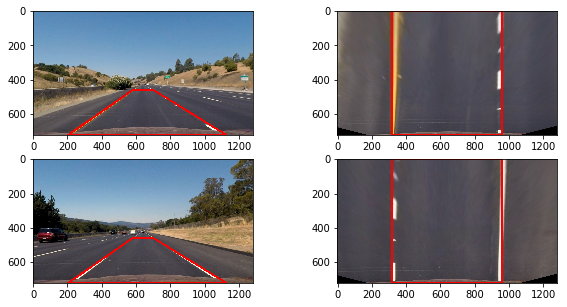

In [9]:
#warper example
test_images=glob.glob('output_images/straight_lines*_undistort.jpg')
test_images+=glob.glob('output_images/test*_undistort.jpg')
plt.figure(figsize=(10,5))
i=0
for imname in test_images:
    image = cv2.imread(imname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    warped_image = warper(image,M)
    mpimg.imsave(test_images[i][:-14]+"_warped.jpg",warped_image)
    if i<=1:
        draw_lines(image,src)
        draw_lines(warped_image,dst)
        #
        plt.subplot(2,2,i*2+1)
        plt.imshow(image)
        plt.subplot(2,2,i*2+2)
        plt.imshow(warped_image)
        #
    i+=1

In [10]:
#binary warper example
test_images=glob.glob('output_images/straight_lines*_binary.jpg')
test_images+=glob.glob('output_images/test*_binary.jpg')
plt.figure(figsize=(10,5))
i=0
for imname in test_images:
    image = mpimg.imread(imname)
    binary_warped_image = warper(image,M)
    mpimg.imsave(test_images[i][:-4]+"_warped.jpg",binary_warped_image)
    i+=1

In [11]:
def blind_winsrc(binary_warped,visualize=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if visualize==True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2,cv2.LINE_AA)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2,cv2.LINE_AA)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if lefty.size==0 :
        left_fit=np.array([0,0,320])
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if righty.size==0 :
        right_fit=np.array([0,0,960])
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize==True:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit,right_fit

In [12]:
def informed_winsrc(binary_warped,left_fit,right_fit,visualize=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if lefty.size>0 :
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if righty.size>0 :
        right_fit = np.polyfit(righty, rightx, 2)
        
    if visualize==True:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit,right_fit

In [13]:
#radius function
def radius(left_fit,right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = [0,0,0]
    right_fit_cr = [0,0,0]
    
    left_fit_cr[0] = left_fit[0]*xm_per_pix/ym_per_pix**2
    right_fit_cr[0] = right_fit[0]*xm_per_pix/ym_per_pix**2
    
    left_fit_cr[1] = left_fit[1]*xm_per_pix/ym_per_pix
    right_fit_cr[1] = right_fit[1]*xm_per_pix/ym_per_pix
    
    left_fit_cr[2] = left_fit[2]*xm_per_pix
    right_fit_cr[2] = right_fit[2]*xm_per_pix
    
    maxy=720
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*maxy*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*maxy*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #calculate lane position
    left_fitx = left_fit_cr[0]*(maxy*ym_per_pix)**2+left_fit_cr[1]*(maxy*ym_per_pix)+left_fit_cr[2]
    right_fitx = right_fit_cr[0]*(maxy*ym_per_pix)**2+right_fit_cr[1]*(maxy*ym_per_pix)+right_fit_cr[2]
    
    center_dist=(left_fitx+right_fitx)/2-1280/2*xm_per_pix
    
    return left_curverad,right_curverad,center_dist

4929.60136023 16764.495061 -0.0351464184823
4146.73518082 2144882.63345 -0.0109679189673
3356.00939777 1507.43216518 0.105131100401
733.904179281 1802.19384752 0.323115213332
1549.31629683 875.865894773 0.0811317612883
1149.7520915 979.258570562 0.2307005689
684.482064218 1183.11450415 -0.0441067475386
1236.67554144 772.850774577 0.223638246032


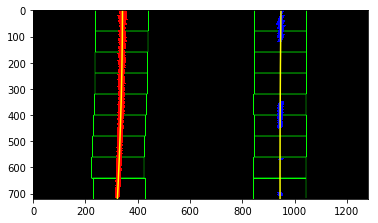

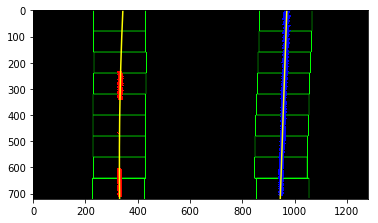

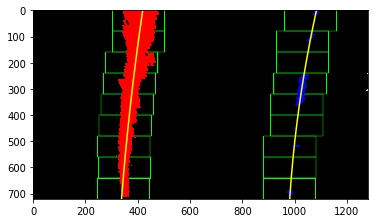

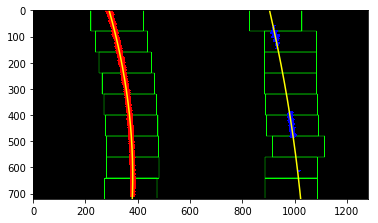

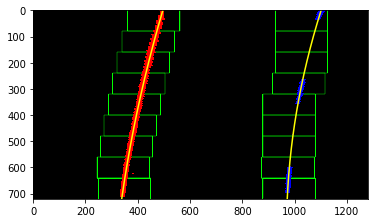

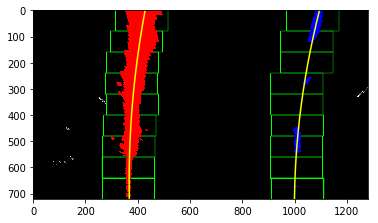

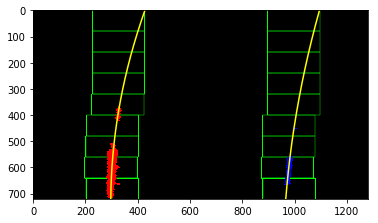

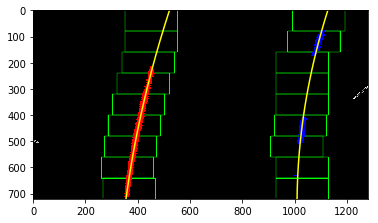

In [14]:
#fit lines
test_images=glob.glob('output_images/straight_lines*_binary_warped.jpg')
test_images+=glob.glob('output_images/test*_binary_warped.jpg')
i=0
for imname in test_images:
    image = cv2.imread(imname)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    plt.figure()
    left_fit,right_fit=blind_winsrc(image,visualize=True)
    left_curverad,right_curverad,center_dist=radius(left_fit,right_fit)
    print(left_curverad,right_curverad,center_dist)
    #plt.figure()
    #left_fit,right_fit=informed_winsrc(image,left_fit,right_fit,visualize=True)
    i+=1

In [15]:
# lane drawing function
def lane_drawing(binary_warped,undist,left_fit,right_fit,radius,center_dist):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
       
    #write text
    font = cv2.FONT_HERSHEY_PLAIN
    if radius<1e4:
        text = 'Curve radius: ' + '{:04.0f}'.format(radius) + 'm'
    else:
        text = 'Curve radius: straight road'
    cv2.putText(newwarp, text, (50,75), font, 3, (255,255,0), 3, cv2.LINE_AA)
    direction = ''
    if center_dist < 0:
        direction = 'right'
    elif center_dist > 0:
        direction = 'left'
    text = 'Lateral position: ' + '{:1.2f}'.format(abs(center_dist)) + 'm ' + direction
    cv2.putText(newwarp, text, (50,125), font, 3, (255,255,0), 3, cv2.LINE_AA)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

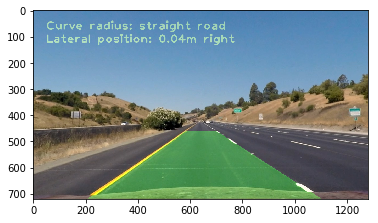

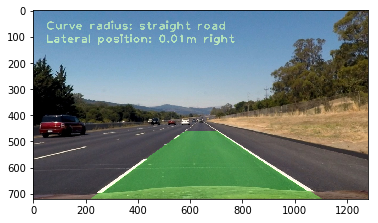

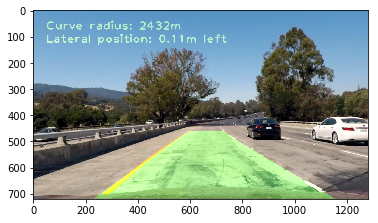

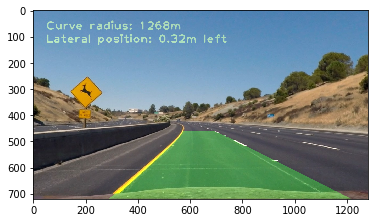

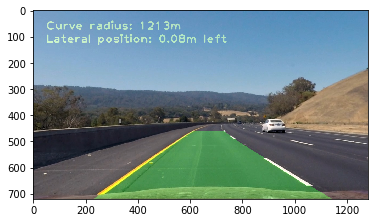

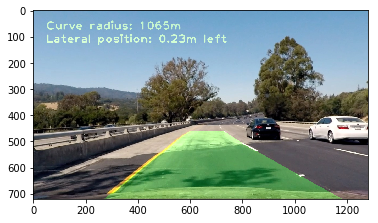

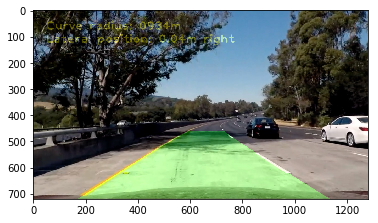

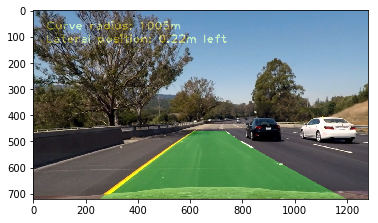

In [16]:
#draw lanes example
test_images_undist=glob.glob('output_images/straight_lines*_undistort.jpg')
test_images_undist+=glob.glob('output_images/test*_undistort.jpg')
test_images_binwarp=glob.glob('output_images/straight_lines*_binary_warped.jpg')
test_images_binwarp+=glob.glob('output_images/test*_binary_warped.jpg')
i=0
for imname1 in test_images_undist:
    undist = cv2.imread(imname1)
    undist = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)
    imname2=test_images_binwarp[i]
    binary_warped = cv2.imread(imname2)
    binary_warped = cv2.cvtColor(binary_warped,cv2.COLOR_BGR2GRAY)
    left_fit,right_fit=blind_winsrc(binary_warped,visualize=False)
    left_curverad,right_curverad,position=radius(left_fit,right_fit)
    curverad=(left_curverad+right_curverad)/2
    plt.figure()
    result=lane_drawing(binary_warped,undist,left_fit,right_fit,curverad,position)
    plt.imshow(result)
    
    i+=1

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        self.fit_list = []  
        self.best_fit = None 
    
    def add_fit(self,fit,n):
        
        if np.isnan(np.sum(fit))==False:
            self.fit_list.append(fit)
            sublist=self.fit_list[-n:]
            #linear moving average
            self.best_fit=np.average(sublist,axis=0,weights=range(1,len(sublist)+1))
  

In [18]:
left_line = Line()
right_line = Line()
def process_image(image):
    
    #undistort
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #binarize
    binary = imbinarize(undist)
    #warp
    binary_warped = warper(binary,M)
    
    #window search
    if (left_line.best_fit==None) | (right_line.best_fit==None):
        left_fit,right_fit=blind_winsrc(binary_warped,visualize=False)
    else:
        left_fit,right_fit=informed_winsrc(binary_warped,left_line.best_fit,right_line.best_fit,visualize=False)
        
    #add fit to list
    left_line.add_fit(left_fit,10)
    right_line.add_fit(right_fit,10)
    
    #curvature calculation on best fit
    left_curverad,right_curverad,position=radius(left_line.best_fit,right_line.best_fit)
    curverad=(left_curverad+right_curverad)/2
    #draw lane
    result=lane_drawing(binary_warped,undist,left_line.best_fit,right_line.best_fit,curverad,position)
    
    return result

In [19]:
from moviepy.editor import VideoFileClip
project_output = 'project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:40<00:00,  4.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 43s
